# Notebook for Celltyping (InsituType) of CosMX RNA Data

# TODO
- clean to test objects

## Instructions

- Make sure to run the QC pipeline first and specify the seurat object as filename in the data loading section
- Helper functions are defined in helper_functions.R (imported with other imports)

## Imports

In [1]:
# Load Packages
library("Seurat")
library("dplyr")
library(ggplot2)
library(gridExtra)
library(patchwork)
library(data.table)
library(Matrix)
library(harmony)
library(ggrepel)
library(pals)
library(RColorBrewer)
library(ggrastr)
library(cluster)
library(ggrepel)
library(gtools)
library(InSituType)
library(HieraType)
library(ComplexHeatmap)
library(scPearsonPCA)
library(tibble)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


Loading required package: Rcpp

Loading required package: grid

ComplexHeatmap version 2.22.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.


In [2]:
# Load helper functions
source("helper_functions.R")

## Data Loading

In [3]:
# Define directories
file_path <- "./data/TMA15/merged_object_ADANA_15.RDS" # Folder containing Seurat objects
out_dir <- "./output/" # Base output folder
# study_name <- "Test"
study_name <- "TMA15"
full_out_dir <- file.path(out_dir, study_name) # Output folder for this study
dir.create(full_out_dir, showWarnings = FALSE, recursive = TRUE)

In [4]:
seu <- readRDS(file_path)

## Setting Parameters

In [14]:
method <- "semisup"
cohorting <- TRUE
subset <- TRUE

# other definitions
region_col <- "region"
ASSAY_NAME <- "RNA"
condition_col <- "condition"

In [ ]:
# Set RNA as Default Assay
DefaultAssay(seu) <- ASSAY_NAME

## Applying subsetting

In [10]:
# Testing Code
set.seed(123) # for reproducibility
if (ncol(seu) > 20000) {
    sampled_cells <- sample(colnames(seu), 20000)
    seu <- seu[, sampled_cells]
}


In [11]:
if (subset) {

    # Filter for Tumor Cores only
    seu <- subset(seu, subset = condition %in% c("T"))

}

# Drop unused levels
seu@meta.data[[region_col]] <- droplevels(seu@meta.data[[region_col]])

Coordinate system already present.
ℹ Adding new coordinate system, which will replace the existing one.


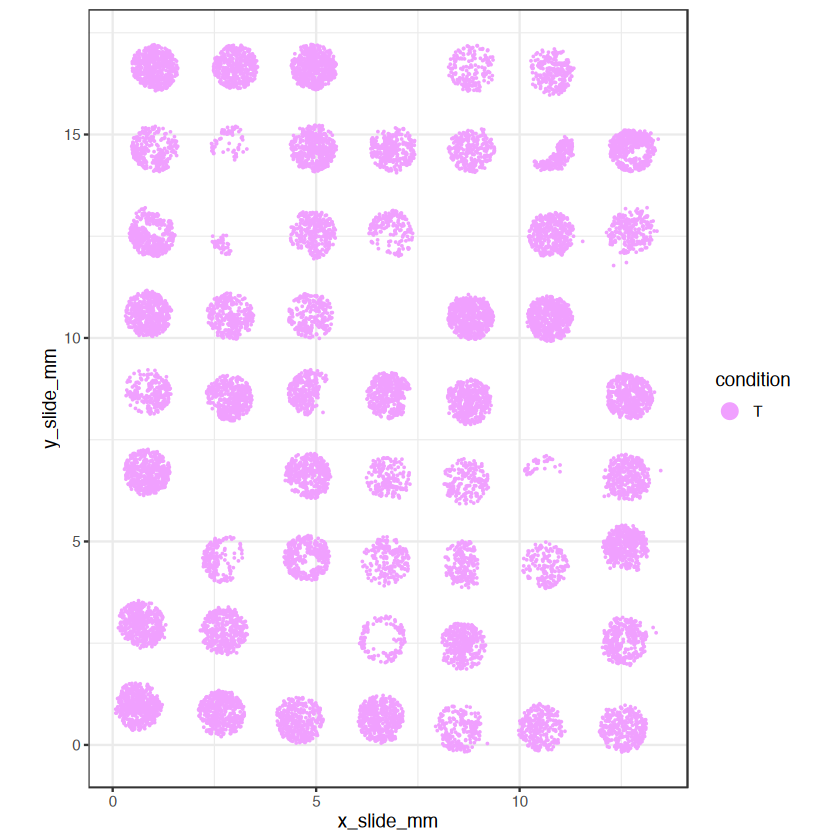

In [16]:
# Visualize the data
xyplot(condition_col, metadata = seu@meta.data, ptsize = 0.01) + coord_fixed()

## Define Inputs for Cell Typing

In [12]:
# Counts Data
counts <- Matrix::t(seu[[ASSAY_NAME]]@counts)

In [13]:
# mean negative control value
negmean <- Matrix::colMeans(seu[["negprobes"]])

## Unsupervised

## Semisupervised

### Parameters

In [18]:
# Parameters
n_clusts <- 10

### Cohorting

In [19]:
if (cohorting) {
    # Extract staining columns
    cohort_features <- as.matrix(seu@meta.data[, c("Mean.PanCK", "Mean.CD45")])
    # Compute cohort assignments
    coh <- fastCohorting(cohort_features, gaussian_transform = TRUE, n_cohorts = 10)
}

### Load Reference Profiles

In [21]:
reference_path <- "./data/InsituType_reference/BreastCancer_6k.profiles.csv"

In [22]:
refprofiles <- read.csv(file.path(reference_path), row.names = 1, header = TRUE)
refprofiles <- refprofiles[is.element(rownames(refprofiles), colnames(counts)), ]

In [23]:
refprofiles[1:5, 1:10]

,B.cell,Conventional.dendritic.cell,Endothelial,Fibroblast,Macrophage,Malignancy,Monocyte,Neutrophil,NK.cell,Pericyte
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A2M,0.19577904,0.13974522,3.3880371,0.3183390,0.6494423,0.07709235,0.17814614,0.14946842,0.21039954,1.41193139
AAAS,0.07594901,0.09006369,0.1364224,0.1057079,0.1154256,0.24387233,0.09785747,0.08630394,0.08000865,0.08562897
AAK1,0.05923513,0.06925690,0.1094636,0.0959437,0.1173349,0.16354170,0.07981507,0.06504065,0.11087552,0.08003812
AAMP,0.13657224,0.11341826,0.1934288,0.1303262,0.1536127,0.28112141,0.13394226,0.10881801,0.12284725,0.11536213
AARS1,0.11447592,0.09643312,0.2066274,0.1405059,0.1403477,0.55345833,0.08252143,0.13008130,0.09861532,0.13162643


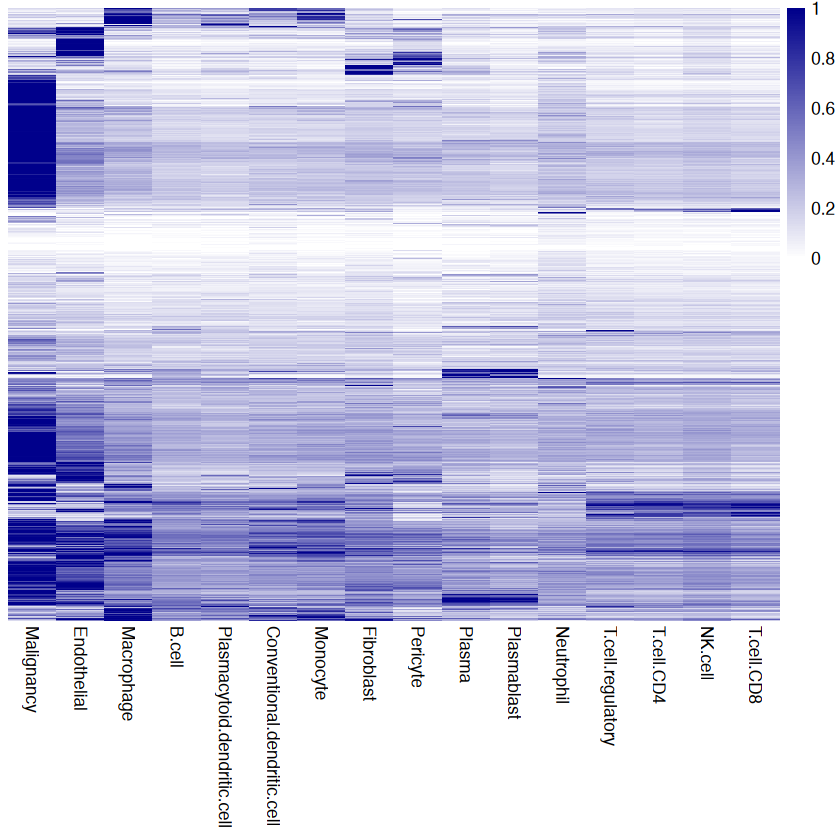

In [24]:
pheatmap::pheatmap(sweep(refprofiles, 1, pmax(apply(refprofiles, 1, max), 0.2), "/"), 
                   col = colorRampPalette(c("white", "darkblue"))(100), 
        treeheight_row = 0,    # hides row dendrogram
        treeheight_col = 0,    # hides column dendrogram
        show_rownames = FALSE  # hides y-axis labels
)

In [25]:
if (method == "semisup") {

  semisup <- insitutype(
    x = counts,
    neg = negmean,
    cohort = if (cohorting) coh else NULL,
    bg = NULL,
    # condensed to save time. n_clusts = 5:15 would be more optimal
    n_clusts = n_clusts,
    reference_profiles = refprofiles,
    update_reference_profiles = FALSE,
    # choosing inadvisably low numbers to speed the vignette; using the defaults
    # in recommended.
    # n_phase1 = 200,
    # n_phase2 = 500,
    # n_phase3 = 2000,
    # n_starts = 1,
    # max_iters = 5
  ) 

}

The following genes in the count data are missing from fixed_profiles and will be omitted from downstream: A1BG,AATK,ACAA2,ACAT2,ACKR1,ADGRE1,ADH1B,ADIRF,AFF2,AGA,AGPAT5,AGRP,AK1,ALDH1L1,ANAPC16,ANGPTL4,ANXA2,AP1S2,AP4E1,APOA1,APOD,AREG,ARNT2,ARX,ASB6,ATF3,ATG4D,ATP1A3,AVPR1B,AXIN2,BIRC3,BOLA2,BST1,C11orf96,C4BPA,C5,C7,C8G,CACNA1A,CADM4,CALML4,CAMTA1,CASP7,CAV2,CCDC80,CCL2,CCL20,CCL21,CCL3,CCNB1,CCND2,CCR10,CD160,CD1C,CD1E,CD22,CD320,CD68,CD83,CD99,CDH11,CDK11A,CDKN2B,CDKN2C,CENPW,CEP164,CFD,CFP,CHIT1,CHL1,CHORDC1,CHPT1,CIB2,CIR1,CLN5,CLU,CMC1,CNIH4,CNTN2,COL18A1,COL1A1,COL3A1,COL4A2,COL4A3,COL5A2,COL8A1,CPAMD8,CPE,CPT2,CRYAB,CSNK2A1,CTNND1,CTSF,CX3CR1,CXCL1,CXCL2,CXCL3,CXCL5,CXCL8,CXCR2,CXCR6,CYCS,CYP1B1,DAAM1,DCN,DCTN5,DDIT3,DERL2,DHX29,DHX38,DISC1,DNAJB1,DTX4,DUSP2,DVL2,EDEM3,EGR1,EIF1AY,ELF4,EMP3,ENDOG,ENY2,EPN1,EREG,ESR2,ESRRA,EZR,F12,FA2H,FAAP20,FAP,FCER1A,FCGR2B,FGF13,FGFBP2,FLRT2,FLT3,FOS,FOSB,FUCA1,FUNDC1,G0S2,GAN,GAR1,GHR,GNG2,GNG7,GPM6A,GPM6B,GPX2,GRIP1,GTF2H5,HADHB,HBB,HBEG

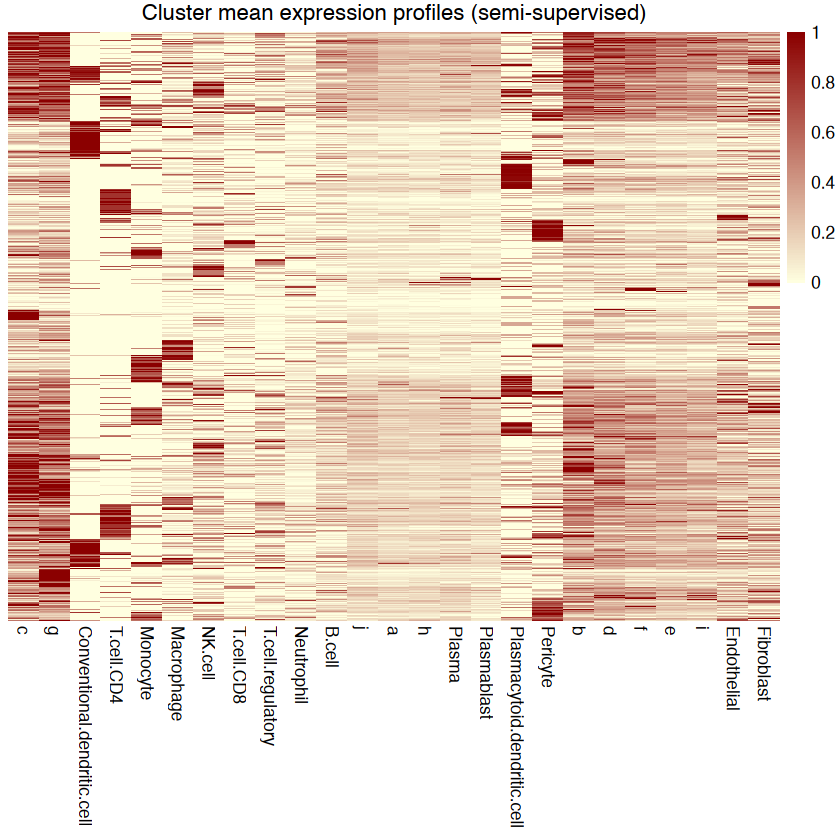

In [26]:
# heatmap(sweep(semisup$profiles, 1, pmax(apply(semisup$profiles, 1, max), .2), "/"), scale = "none",
#         main = "Cluster mean expression profiles (semi-supervised)")

pheatmap::pheatmap(sweep(semisup$profiles, 1, pmax(apply(semisup$profiles, 1, max), .2), "/"), scale = "none", col = colorRampPalette(c("lightyellow", "darkred"))(100),
        main = "Cluster mean expression profiles (semi-supervised)", treeheight_row = 0, treeheight_col = 0, show_rownames = FALSE)

In [ ]:
clusters <- semisup$clust
all(names(clusters) %in% colnames(seu))

# Create a vector with NA for all cells, then fill where available
cluster_metadata <- rep(NA, ncol(seu))
names(cluster_metadata) <- colnames(seu)

# Fill in clusters for matching cells
cluster_metadata[names(clusters)] <- clusters

# Add to Seurat object metadata
if (cohorting) {
    seu$IST_clusters_cohort_initial <- as.factor(cluster_metadata)
    table(seu$IST_clusters_cohort_initial)
    seu$seurat_clusters <- as.factor(cluster_metadata)
} else {
    seu$IST_clusters_cohort_initial <- as.factor(cluster_metadata)
    table(seu$IST_clusters_initial)
    seu$seurat_clusters <- as.factor(cluster_metadata)
}


### Saving data

In [ ]:
suffix <- "_initial"
saveRDS(seu, file.path(full_out_dir, paste0("merged_object_", study_name, "_IST_", method, suffix,".RDS")))

In [ ]:
saveRDS(semisup, file.path(full_out_dir, paste0("InsituType_Result_", study_name, "_", method, suffix,".RDS")))

### Visualizing Initial Results